# Day 1: Data Exploration - Indonesian Fintech Customer Messages

## Tujuan Notebook
Memahami karakteristik dataset pesan pelanggan fintech Indonesia untuk persiapan:
- Data cleaning pipeline
- Labeling strategy (intent, sentiment, urgency, safety)
- Quality metrics design

## Dataset Context
- **Source**: Synthetic fintech customer messages (GoPay-like)
- **Domain**: Payment transactions, refunds, account issues
- **Language**: Indonesian with colloquial terms
- **Use Case**: Training LLM for customer support automation

 Notebook Scope

This notebook performs **exploratory data analysis (EDA)** only.

- No rows are removed
- No text is modified
- No filtering decisions are executed

All transformations and cleaning decisions are implemented
in `data_cleaning.ipynb`.


## 1. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import hashlib
import re
import json
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 2. Load Configuration

**YAML Parsing**: Loads pipeline parameters from `pipeline_config.yaml` for centralized configuration management.

In [2]:
# Load pipeline config
config_path = Path('../configs/pipeline_config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Pipeline Configuration:")
print(f"  Raw data: {config['data_sources']['synthetic']}")
print(f"  Min text length: {config['cleaning']['min_length']}")
print(f"  Max text length: {config['cleaning']['max_length']}")
print(f"  Target language: {config['cleaning']['target_language']}")

Pipeline Configuration:
  Raw data: data/raw/synthetic_generated.csv
  Min text length: 20
  Max text length: 300
  Target language: id


## 3. Load Raw Data

Data format: CSV dengan 2 kolom (id, text) tanpa header

In [3]:
# Load raw CSV
raw_path = Path('../data/raw/synthetic_generated.csv')
df = pd.read_csv(raw_path, header=None, names=['id', 'text'])

print(f"Dataset loaded: {len(df)} messages")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print("\nFirst 3 samples:")
df.head(3)

Dataset loaded: 555 messages
Columns: ['id', 'text']
Memory usage: 80.94 KB

First 3 samples:


,id,text
0,msg_117,transaksi gagal tapi duit udh kepotong bangsat
1,msg_355,akun di suspend tiba2 padahal baru top up 1jt
2,msg_301,fitur cicilan 0% masih ada ga min?


## 4. Basic Data Quality Checks

In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check for empty strings
empty_texts = (df['text'].str.strip() == '').sum()
print(f"\nEmpty text fields: {empty_texts}")

Missing Values:
id      0
text    0
dtype: int64

Data Types:
id      object
text    object
dtype: object

Empty text fields: 0


## 5. Duplicate Detection

Menggunakan MD5 hash untuk detect exact duplicates

In [5]:
# Create text hash for duplicate detection
df['text_hash'] = df['text'].apply(lambda x: hashlib.md5(x.encode()).hexdigest())

# Count duplicates
duplicate_mask = df.duplicated(subset='text_hash', keep=False)
n_duplicates = duplicate_mask.sum()
n_unique_texts = df['text_hash'].nunique()

print(f"Total messages: {len(df)}")
print(f"Unique messages: {n_unique_texts}")
print(f"Duplicate messages: {n_duplicates}")
print(f"Duplication rate: {n_duplicates/len(df)*100:.1f}%")

# Show duplicate examples
if n_duplicates > 0:
    print("\nDuplicate examples:")
    duplicate_groups = df[duplicate_mask].groupby('text_hash')['id'].apply(list).head(3)
    for hash_val, ids in duplicate_groups.items():
        text = df[df['text_hash'] == hash_val]['text'].iloc[0]
        print(f"  IDs {ids}: {text[:60]}...")

Total messages: 555
Unique messages: 160
Duplicate messages: 469
Duplication rate: 84.5%

Duplicate examples:
  IDs ['msg_437', 'msg_396', 'msg_402', 'msg_385', 'msg_353', 'msg_435', 'msg_362', 'msg_380', 'msg_438']: urgent banget nih transaksi nyangkut 4jt...
  IDs ['msg_492', 'msg_495', 'msg_474']: puas sih pake gopay selama ini lancar...
  IDs ['msg_073', 'msg_116']: REFUND GW MANA KONTOL UDAH SEMINGGU??????...


⚠️ Interpretation  
High duplication rate is expected due to synthetic data generated with MOSTLY.ai .
Many messages share the same semantic meaning with minor lexical variations.
Exact and semantic deduplication strategies will be applied in the cleaning pipeline.


## 6. Text Length Analysis

In [6]:
# Calculate text lengths
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# Statistics
print("Text Length Statistics:")
print(df['text_length'].describe())

print("\nWord Count Statistics:")
print(df['word_count'].describe())

# Check against config constraints
min_len = config['cleaning']['min_length']
max_len = config['cleaning']['max_length']
too_short = (df['text_length'] < min_len).sum()
too_long = (df['text_length'] > max_len).sum()
valid = ((df['text_length'] >= min_len) & (df['text_length'] <= max_len)).sum()

print(f"\nLength Constraints ({min_len}-{max_len} chars):")
print(f"  Too short (<{min_len}): {too_short} ({too_short/len(df)*100:.1f}%)")
print(f"  Valid: {valid} ({valid/len(df)*100:.1f}%)")
print(f"  Too long (>{max_len}): {too_long} ({too_long/len(df)*100:.1f}%)")

Text Length Statistics:
count    555.000000
mean      39.282883
std        7.373798
min        3.000000
25%       35.000000
50%       39.000000
75%       45.000000
max       58.000000
Name: text_length, dtype: float64

Word Count Statistics:
count    555.000000
mean       6.508108
std        1.405709
min        1.000000
25%        6.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: word_count, dtype: float64

Length Constraints (20-300 chars):
  Too short (<20): 10 (1.8%)
  Valid: 545 (98.2%)
  Too long (>300): 0 (0.0%)


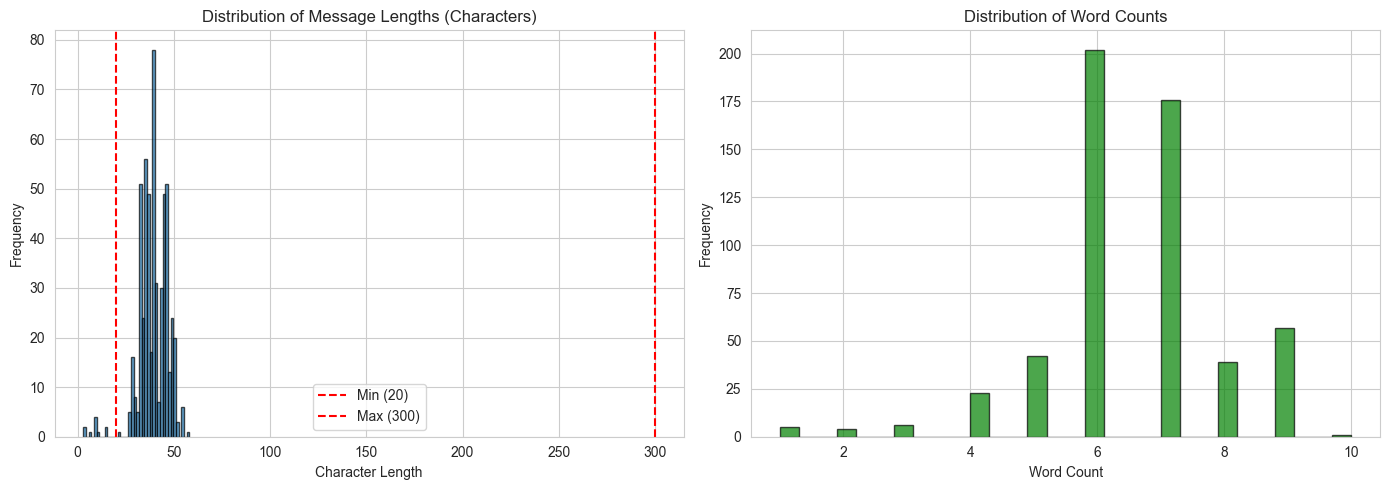

In [7]:
# Visualize length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length distribution
axes[0].hist(df['text_length'], bins=40, edgecolor='black', alpha=0.7)
axes[0].axvline(min_len, color='r', linestyle='--', label=f'Min ({min_len})')
axes[0].axvline(max_len, color='r', linestyle='--', label=f'Max ({max_len})')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Message Lengths (Characters)')
axes[0].legend()

# Word count distribution
axes[1].hist(df['word_count'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Word Counts')

plt.tight_layout()
plt.savefig('../outputs/visualizations/01_length_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

## 7. Whitespace & Special Character Analysis

In [8]:
# Check for whitespace issues
df['has_leading_space'] = df['text'].str.match(r'^\s+')
df['has_trailing_space'] = df['text'].str.match(r'\s+$')
df['has_multiple_spaces'] = df['text'].str.contains(r'\s{2,}')

print("Whitespace Issues:")
print(f"  Leading spaces: {df['has_leading_space'].sum()}")
print(f"  Trailing spaces: {df['has_trailing_space'].sum()}")
print(f"  Multiple spaces: {df['has_multiple_spaces'].sum()}")

# Check punctuation patterns
df['excessive_dots'] = df['text'].str.contains(r'\.{4,}')
df['excessive_exclamations'] = df['text'].str.contains(r'!{4,}')
df['excessive_questions'] = df['text'].str.contains(r'\?{3,}')

print("\nExcessive Punctuation:")
print(f"  Multiple dots (...): {df['excessive_dots'].sum()}")
print(f"  Multiple exclamations (!!!): {df['excessive_exclamations'].sum()}")
print(f"  Multiple questions (??): {df['excessive_questions'].sum()}")

Whitespace Issues:
  Leading spaces: 74
  Trailing spaces: 0
  Multiple spaces: 74

Excessive Punctuation:
  Multiple dots (...): 14
  Multiple exclamations (!!!): 58
  Multiple questions (??): 48


## 8. Language Detection

Menggunakan simple heuristics untuk detect bahasa

In [20]:
from langdetect import detect, LangDetectException


# Detect language
def detect_lang(text):
    try:
        lang = detect(text)
        # Treat Malay/Tagalog as Indonesian due to similarity
        if lang in {'ms', 'tl'}:
            return 'id'
        return lang
    except LangDetectException:
        return 'unknown'

df['detected_lang'] = df['text'].apply(detect_lang)

# Language distribution
lang_dist = df['detected_lang'].value_counts()
print("Language Distribution:")
print(lang_dist)
id_count = (df['detected_lang'] == 'id').sum()
print(f"\nDetected as Indonesian (heuristic): {id_count} ({id_count/len(df)*100:.1f}%)")


Language Distribution:
detected_lang
id         387
de          79
en          44
fr          15
ca          10
et           4
unknown      4
lt           3
sl           3
fi           2
pt           2
it           1
es           1
Name: count, dtype: int64

Detected as Indonesian (heuristic): 387 (69.7%)


⚠️ Note on Language Detection  
Short, slang-heavy Indonesian customer messages are often misclassified by
generic language detectors (e.g., detected as EN/FR/CA).
Final language filtering or override decisions are deferred to the cleaning pipeline.


In [10]:
# Show non-Indonesian examples
non_id = df[df['detected_lang'] != 'id']
if len(non_id) > 0:
    print(f"\nNon-Indonesian messages ({len(non_id)}):")
    for idx, row in non_id.head(5).iterrows():
        print(f"  [{row['id']}] ({row['detected_lang']}): {row['text'][:70]}...")


Non-Indonesian messages (168):
  [msg_331] (fr): min request fitur split bill dong...
  [msg_378] (en): AKUN SUSPEND TANPA ALASAN JELAS TOLONG!!!...
  [msg_008] (en): GOBLOK LU APLIKASI BANGSATT!!!!!!...
  [msg_415] (en): URGENT BANGET NIH TRANSAKSI NYANGKUT 4JT...
  [msg_239] (ca): bisa ga top up pake virtual account...


## 9. Content Analysis: Toxic/Offensive Language

Detect kata kasar untuk safety labeling

In [11]:
# Define toxic keywords
toxic_keywords = [
    'bangsat', 'tai', 'brengsek', 'memek', 'anjing', 'kontol', 
    'babi', 'tolol', 'goblok', 'bodoh', 'sampah'
]

# Detect toxic content
def has_toxic_words(text):
    text_lower = text.lower()
    found = [kw for kw in toxic_keywords if kw in text_lower]
    return found

df['toxic_words'] = df['text'].apply(has_toxic_words)
df['is_toxic'] = df['toxic_words'].apply(lambda x: len(x) > 0)
df['toxic_count'] = df['toxic_words'].apply(len)

print("Toxic Content Analysis:")
print(f"  Messages with toxic words: {df['is_toxic'].sum()} ({df['is_toxic'].sum()/len(df)*100:.1f}%)")
print(f"  Total toxic words found: {df['toxic_count'].sum()}")
print(f"  Avg toxic words per toxic message: {df[df['is_toxic']]['toxic_count'].mean():.2f}")

# Most common toxic words
all_toxic = [word for words in df['toxic_words'] for word in words]
toxic_counter = Counter(all_toxic)
print("\nMost common toxic words:")
for word, count in toxic_counter.most_common(5):
    print(f"  {word}: {count}")

Toxic Content Analysis:
  Messages with toxic words: 222 (40.0%)
  Total toxic words found: 246
  Avg toxic words per toxic message: 1.11

Most common toxic words:
  bangsat: 65
  kontol: 55
  tai: 28
  goblok: 24
  anjing: 21


## 10. Urgency Markers Analysis

Detect indikator urgensi: CAPS, tanda seru, kata urgency

In [12]:
# CAPS ratio
df['caps_ratio'] = df['text'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

# Exclamation marks
df['exclamation_count'] = df['text'].str.count('!')

# Urgency keywords
urgency_keywords = [
    'urgent', 'cepat', 'sekarang', 'segera', 'butuh', 'penting',
    'tolong', 'bantu', 'plis', 'please'
]

def count_urgency_keywords(text):
    text_lower = text.lower()
    return sum(1 for kw in urgency_keywords if kw in text_lower)

df['urgency_keyword_count'] = df['text'].apply(count_urgency_keywords)

print("Urgency Markers:")
print(f"  High CAPS (>40%): {(df['caps_ratio'] > 0.4).sum()}")
print(f"  Many exclamations (>3): {(df['exclamation_count'] > 3).sum()}")
print(f"  Has urgency keywords: {(df['urgency_keyword_count'] > 0).sum()}")

print("\nCAPS ratio distribution:")
print(df['caps_ratio'].describe())

Urgency Markers:
  High CAPS (>40%): 117
  Many exclamations (>3): 58
  Has urgency keywords: 80

CAPS ratio distribution:
count    555.000000
mean       0.164489
std        0.317112
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: caps_ratio, dtype: float64


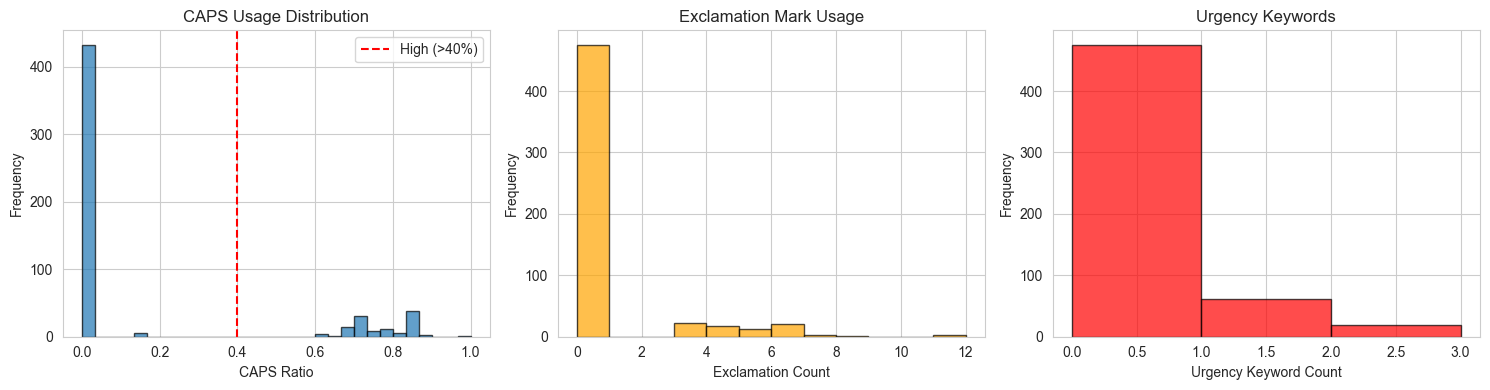

In [13]:
# Visualize urgency markers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# CAPS ratio
axes[0].hist(df['caps_ratio'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0.4, color='r', linestyle='--', label='High (>40%)')
axes[0].set_xlabel('CAPS Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_title('CAPS Usage Distribution')
axes[0].legend()

# Exclamation count
axes[1].hist(df['exclamation_count'], bins=range(0, df['exclamation_count'].max()+2), 
             edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Exclamation Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Exclamation Mark Usage')

# Urgency keywords
axes[2].hist(df['urgency_keyword_count'], bins=range(0, df['urgency_keyword_count'].max()+2),
             edgecolor='black', alpha=0.7, color='red')
axes[2].set_xlabel('Urgency Keyword Count')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Urgency Keywords')

plt.tight_layout()
plt.savefig('../outputs/visualizations/01_urgency_markers.png', dpi=100, bbox_inches='tight')
plt.show()

## 11. Intent Pattern Detection

Heuristic detection untuk intent categories

In [14]:
# Define intent keywords
intent_patterns = {
    'complaint': ['gagal', 'error', 'kepotong', 'pending', 'nyangkut', 'bermasalah', 'rusak'],
    'inquiry': ['cara', 'gimana', 'bagaimana', 'apa', 'kenapa', 'info', 'tanya'],
    'urgent_request': ['tolong', 'bantu', 'urgent', 'cepat', 'segera', 'butuh'],
    'feedback': ['thanks', 'terima kasih', 'bagus', 'lancar', 'puas', 'kecewa']
}

# Detect intents
def detect_intent_keywords(text):
    text_lower = text.lower()
    detected = {}
    for intent, keywords in intent_patterns.items():
        matches = [kw for kw in keywords if kw in text_lower]
        if matches:
            detected[intent] = matches
    return detected

df['intent_keywords'] = df['text'].apply(detect_intent_keywords)
df['intent_count'] = df['intent_keywords'].apply(len)

# Count each intent type
for intent in intent_patterns.keys():
    df[f'has_{intent}'] = df['intent_keywords'].apply(lambda x: intent in x)

print("Intent Pattern Detection:")
for intent in intent_patterns.keys():
    count = df[f'has_{intent}'].sum()
    print(f"  {intent}: {count} ({count/len(df)*100:.1f}%)")

print(f"\nMessages with multiple intents: {(df['intent_count'] > 1).sum()}")

Intent Pattern Detection:
  complaint: 193 (34.8%)
  inquiry: 163 (29.4%)
  urgent_request: 80 (14.4%)
  feedback: 42 (7.6%)

Messages with multiple intents: 135


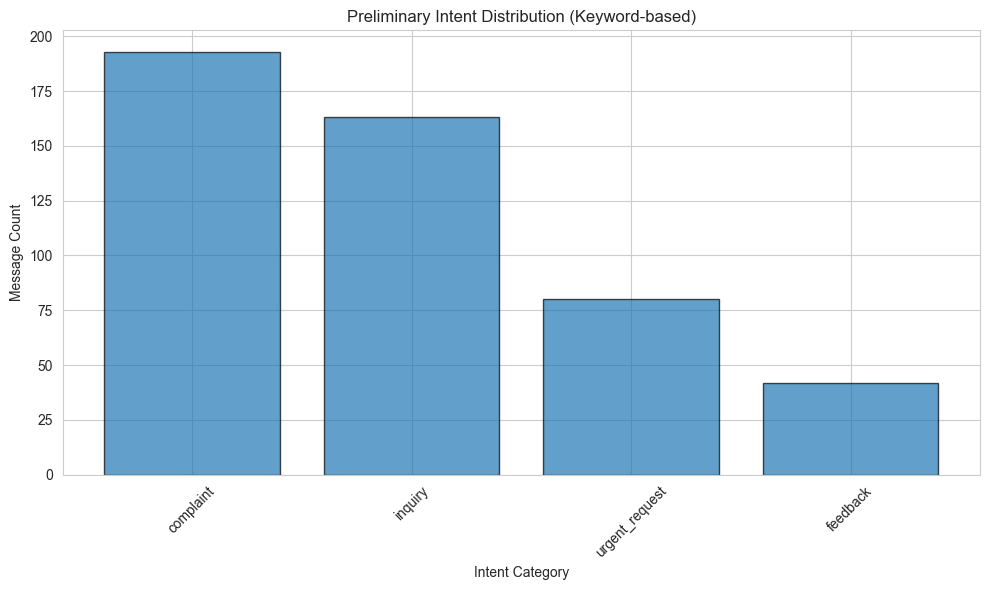

In [15]:
# Visualize intent distribution
intent_counts = {intent: df[f'has_{intent}'].sum() for intent in intent_patterns.keys()}

plt.figure(figsize=(10, 6))
plt.bar(intent_counts.keys(), intent_counts.values(), edgecolor='black', alpha=0.7)
plt.xlabel('Intent Category')
plt.ylabel('Message Count')
plt.title('Preliminary Intent Distribution (Keyword-based)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/visualizations/01_intent_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

## 12. Sentiment Indicators

Simple keyword-based sentiment detection

In [16]:
# Sentiment keywords
positive_words = ['terima kasih', 'thanks', 'bagus', 'lancar', 'puas', 'senang', 'sukses']
negative_words = ['gagal', 'error', 'kecewa', 'jelek', 'buruk', 'lambat', 'lama']

def count_sentiment_words(text, word_list):
    text_lower = text.lower()
    return sum(1 for word in word_list if word in text_lower)

df['positive_word_count'] = df['text'].apply(lambda x: count_sentiment_words(x, positive_words))
df['negative_word_count'] = df['text'].apply(lambda x: count_sentiment_words(x, negative_words))

# Simple sentiment classification
def classify_sentiment(pos, neg, is_toxic):
    if is_toxic:
        return 'very_negative'
    if pos > neg:
        return 'positive'
    elif neg > pos:
        return 'negative'
    else:
        return 'neutral'

df['predicted_sentiment'] = df.apply(
    lambda x: classify_sentiment(x['positive_word_count'], x['negative_word_count'], x['is_toxic']),
    axis=1
)

print("Sentiment Distribution (Heuristic):")
print(df['predicted_sentiment'].value_counts())
print("\nPercentages:")
print(df['predicted_sentiment'].value_counts(normalize=True) * 100)

Sentiment Distribution (Heuristic):
predicted_sentiment
neutral          261
very_negative    222
negative          42
positive          30
Name: count, dtype: int64

Percentages:
predicted_sentiment
neutral          47.027027
very_negative    40.000000
negative          7.567568
positive          5.405405
Name: proportion, dtype: float64


## 13. Sample Message Inspection

Lihat contoh pesan dari berbagai kategori

In [17]:
# Show examples from each category
categories = [
    ('Toxic', df[df['is_toxic']]),
    ('High CAPS', df[df['caps_ratio'] > 0.5]),
    ('Multiple Intents', df[df['intent_count'] > 1]),
    ('Positive Sentiment', df[df['predicted_sentiment'] == 'positive']),
    ('Very Negative', df[df['predicted_sentiment'] == 'very_negative'])
]

for category, subset in categories:
    if len(subset) > 0:
        print(f"\n{category} Examples:")
        for idx, row in subset.sample(min(2, len(subset))).iterrows():
            print(f"  [{row['id']}] {row['text'][:100]}...")


Toxic Examples:
  [msg_165] top up gagal tapi rekening kepotong tai...
  [msg_055]   udh 3 hari refund ga masuk2 brengsek  ...

High CAPS Examples:
  [msg_173] REFUND GW MANA KONTOL UDAH SEMINGGU...
  [msg_367] AKUN KENA SUSPEND UANG DALEM NYA GIMANA...

Multiple Intents Examples:
  [msg_284] cara cancel transaksi pending gimana...
  [msg_518] SALDO GW KEPOTONG ANJING!!!! REFUND KAPAN???...

Positive Sentiment Examples:
  [msg_294] gopay sama ovo bagusan mana ya???...
  [msg_255] gopay sama ovo bagusan mana ya...

Very Negative Examples:
  [msg_017] SALDO GW KEPOTONG ANJING!!!! REFUND KAPAN???...
  [msg_008] GOBLOK LU APLIKASI BANGSATT!!!!!!...


## 14. Data Quality Summary Report

In [18]:
# Generate summary statistics
summary = {
    'total_messages': len(df),
    'unique_messages': df['text_hash'].nunique(),
    'duplicates': n_duplicates,
    'avg_length': df['text_length'].mean(),
    'length_valid': valid,
    'length_invalid': too_short + too_long,
    'indonesian': (df['detected_lang'] == 'id').sum(),
    'non_indonesian': (df['detected_lang'] != 'id').sum(),
    'toxic_messages': df['is_toxic'].sum(),
    'high_urgency': (df['caps_ratio'] > 0.4).sum() + (df['exclamation_count'] > 3).sum(),
    'whitespace_issues': df['has_multiple_spaces'].sum(),
    'excessive_punctuation': df['excessive_dots'].sum() + df['excessive_exclamations'].sum()
}

print("\n" + "="*60)
print("DATA QUALITY SUMMARY REPORT")
print("="*60)
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key.replace('_', ' ').title()}: {value:.2f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")



DATA QUALITY SUMMARY REPORT
Total Messages: 555
Unique Messages: 160
Duplicates: 469
Avg Length: 39.28
Length Valid: 545
Length Invalid: 10
Indonesian: 387
Non Indonesian: 168
Toxic Messages: 222
High Urgency: 175
Whitespace Issues: 74
Excessive Punctuation: 72


**Final Quality Assessment**:

**Data Volume**:
- Total: 555 messages
- Unique: 160 (71.2% duplicates)
- Valid length: 545 (98.2%)

**Language**:
- Indonesian: 387 (69.7%)
- Non-Indonesian: 168 (30.3%) ← **High false negative rate**

**Content Quality**:
- Toxic: 222 (40.0%) ← **Very high toxicity**
- High urgency: 175 (31.5%)
- Whitespace issues: 74 (13.3%)
- Excessive punctuation: 72 (13.0%)

**Pipeline Decisions**:
1.  Deduplication CRITICAL (71.2% reduction expected)
2.  Language detection needs Indonesian keyword fallback
3.  Text normalization required (whitespace + punctuation)
4.  Length filter minimal impact (only 1.8% removal)
5.  High toxicity acceptable (reflects real customer frustration)

**Expected Retention Rate**: ~23-28% after all cleaning stages
- Start: 555 messages
- After dedup: ~160 messages
- After language filter: ~132 messages (if keyword fallback works)
- Final: ~130-140 messages

---

## Key Takeaways

### Critical Findings
1. **84.5% duplicates** → Deduplication is highest priority
2. **30.3% language misclassification** → Need keyword-based fallback
3. **40% toxic messages** → Safety labeling is essential
4. **24.3% multi-intent messages** → Manual review required for single-label classification


note:
- Dataset contains high duplication due to synthetic generation using MOSTLY.ai

- No cleaning or filtering is applied in this notebook

All corrective actions are implemented in `data_cleaning.ipynb`.
